In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [153]:
# Data Loading and Preparation
def load_and_prepare_data():
    main_df = pd.read_csv('../data/World Energy Consumption.csv')
    countries = ['New Zealand']
    columns_needed = ['country', 'year', 'primary_energy_consumption', 
                     'renewables_consumption', 'gdp', 'population']
    
    data = main_df[main_df['country'].isin(countries)][columns_needed].dropna()
    data = data.set_index('year').sort_index()
    return data


In [154]:
# Exploratory Data Analysis
def plot_energy_trends(data):
    plt.figure(figsize=(15, 6))
    
    # Primary Energy
    plt.subplot(1, 2, 1)
    plt.plot(data['primary_energy_consumption'], label='Primary Energy')
    plt.title('Primary Energy Consumption')
    plt.xlabel('Year')
    plt.ylabel('TWh')
    plt.grid(True)
    
    # Renewables
    plt.subplot(1, 2, 2)
    plt.plot(data['renewables_consumption'], label='Renewables', color='green')
    plt.title('Renewables Consumption')
    plt.xlabel('Year')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

In [155]:
# Model Selection
def select_best_model(series, exog=None):
    models = {
        'SARIMA(1,1,1)': (1,1,1),
        'SARIMA(0,1,1)': (0,1,1),
        'SARIMA(1,1,0)': (1,1,0),
        'SARIMA(2,1,2)': (2,1,2)
    }
    
    best_aic = np.inf
    best_model = None
    
    for name, order in models.items():
        try:
            model = SARIMAX(series, exog=exog, order=order, seasonal_order=(0,0,0,0))
            model_fit = model.fit(disp=False)
            
            if model_fit.aic < best_aic:
                best_aic = model_fit.aic
                best_model = model_fit
                best_name = name
                
            print(f"{name} - AIC: {model_fit.aic:.1f}")
        except Exception as e:
            print(f"{name} failed: {str(e)}")
            continue
    
    print(f"\nSelected model: {best_name} with AIC: {best_aic:.1f}")
    return best_model

In [156]:
def forecast_energy_consumption(country, target_column, years_to_forecast=5):
    # Load and prepare data
    data = load_and_prepare_data()
    country_data = data[data['country'] == country]
    series = country_data[target_column]
    exog_vars = country_data[['gdp', 'population']]
    
    # Convert index to proper integer years
    series.index = series.index.astype(int)
    exog_vars.index = exog_vars.index.astype(int)
    last_year = series.index[-1]
    
    # Model selection
    model = select_best_model(series, exog=exog_vars)
    
    # Prepare future exogenous variables with proper year index
    future_years = range(last_year + 1, last_year + years_to_forecast + 1)
    future_exog = pd.DataFrame(
        [exog_vars.loc[last_year].values] * years_to_forecast,
        index=future_years,
        columns=exog_vars.columns
    )
    
    # Generate forecast
    forecast = model.get_forecast(steps=years_to_forecast, exog=future_exog)
    forecast_mean = forecast.predicted_mean
    forecast_mean.index = future_years  # Ensure proper year index
    conf_int = forecast.conf_int()
    conf_int.index = future_years
    
    # Create visualization with proper year handling
    plt.figure(figsize=(12, 6))
    
    # Plot historical data with integer years
    plt.plot(series.index.astype(int), series, 'bo-', 
            label=f'Historical Data ({series.index[0]}-{last_year})',
            markersize=6)
    
    # Plot forecast with integer years
    plt.plot(forecast_mean.index.astype(int), forecast_mean, 'ro--', 
            label=f'Forecast ({future_years[0]}-{future_years[-1]})',
            markersize=6)
    
    # Confidence intervals
    plt.fill_between(forecast_mean.index.astype(int),
                   conf_int.iloc[:, 0],
                   conf_int.iloc[:, 1], 
                   color='gray', alpha=0.2, label='95% CI')
    
    # Formatting
    plt.title(f'{country} {target_column.replace("_", " ").title()} Forecast')
    plt.xlabel('Year')
    plt.ylabel('Consumption (TWh)')
    
    # Set x-axis ticks properly
    all_years = sorted(list(series.index) + list(future_years))
    min_year = min(all_years)
    max_year = max(all_years)
    
    # Show every year if <15, otherwise every 2-5 years
    if (max_year - min_year) <= 15:
        plt.xticks(range(min_year, max_year + 1), rotation=45)
    else:
        step = 2 if (max_year - min_year) <= 30 else 5
        plt.xticks(range(min_year, max_year + 1, step), rotation=45)
    
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Return forecast with proper years
    forecast_results = pd.DataFrame({
        'Year': future_years,
        'Forecast': forecast_mean.round(2),
        'Lower_CI': conf_int.iloc[:, 0].round(2),
        'Upper_CI': conf_int.iloc[:, 1].round(2)
    })
    
    return forecast_results

In [157]:
# Model Evaluation
def evaluate_model(country, target_column):
    data = load_and_prepare_data()
    country_data = data[data['country'] == country]
    series = country_data[target_column]
    exog_vars = country_data[['gdp', 'population']]
    
    # Train-test split (80-20)
    train_size = int(len(series) * 0.8)
    train, test = series.iloc[:train_size], series.iloc[train_size:]
    exog_train, exog_test = exog_vars.iloc[:train_size], exog_vars.iloc[train_size:]
    
    # Model fitting
    model = select_best_model(train, exog=exog_train)
    forecast = model.get_forecast(steps=len(test), exog=exog_test)
    
    # Calculate metrics
    mae = mean_absolute_error(test, forecast.predicted_mean)
    rmse = np.sqrt(mean_squared_error(test, forecast.predicted_mean))
    
    print(f"\nModel Evaluation for {target_column}:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    
    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train, 'bo-', label='Training Data')
    plt.plot(test.index, test, 'go-', label='Actual Test Data')
    plt.plot(test.index, forecast.predicted_mean, 'ro--', label='Forecast')
    plt.fill_between(test.index,
                   forecast.conf_int().iloc[:, 0],
                   forecast.conf_int().iloc[:, 1], color='gray', alpha=0.2)
    plt.title(f'Model Evaluation: {target_column.replace("_", " ").title()}')
    plt.xlabel('Year')
    plt.ylabel('Consumption (TWh)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [158]:
def generate_energy_report(country):
    data = load_and_prepare_data()
    plot_energy_trends(data[data['country'] == country])
    
    print("\n     Primary Energy Consumption     ")
    primary_forecast = forecast_energy_consumption(country, 'primary_energy_consumption')
    evaluate_model(country, 'primary_energy_consumption')
    
    print("\n     Renewables Consumption     ")
    renewables_forecast = forecast_energy_consumption(country, 'renewables_consumption')
    evaluate_model(country, 'renewables_consumption')
    
    # Calculate renewable share - we need to extract the 'Forecast' values from the Series
    last_primary = primary_forecast['Forecast'].iloc[-1]
    last_renewable = renewables_forecast['Forecast'].iloc[-1]
    renewable_share = (last_renewable / last_primary) * 100
    
    print("\n     2030 Projection     ")
    print(f"Primary Energy: {last_primary:.2f} TWh")
    print(f"Renewables: {last_renewable:.2f} TWh")
    print(f"Renewable Share: {renewable_share:.1f}%")
    
    return {
        'primary_energy_forecast': primary_forecast,
        'renewables_forecast': renewables_forecast,
        'renewable_share': renewable_share
    }

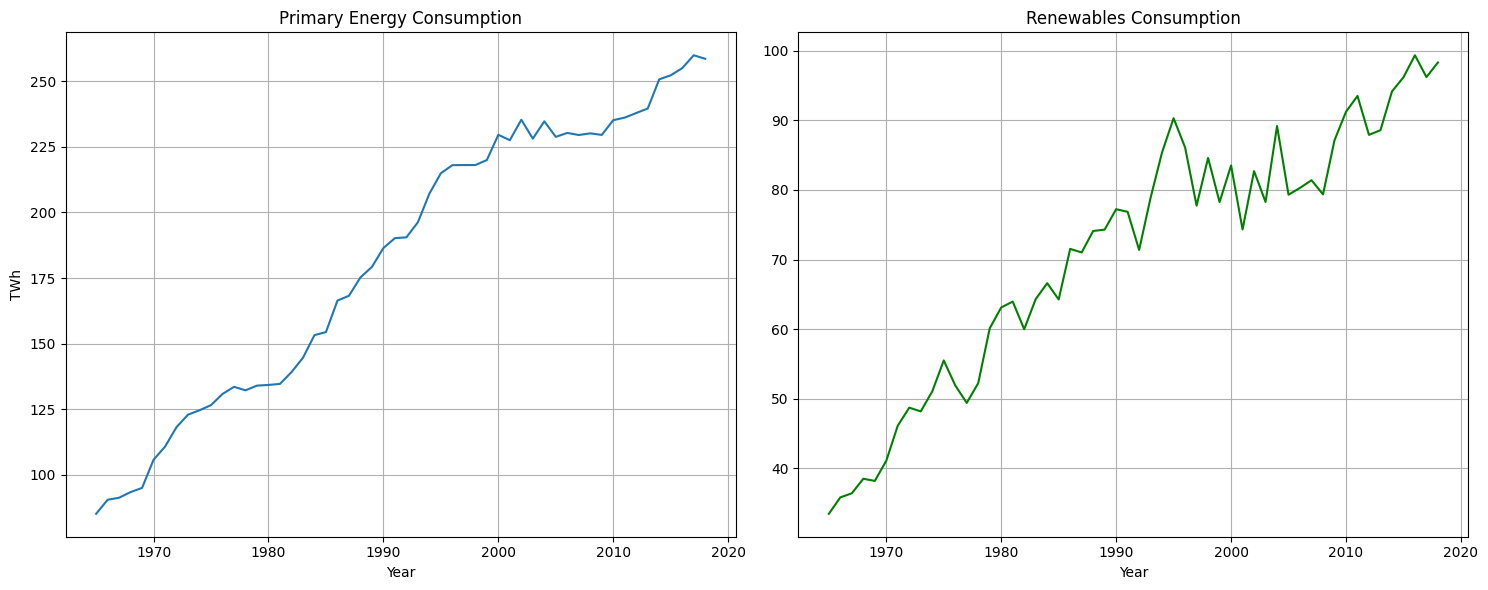


     Primary Energy Consumption     
SARIMA(1,1,1) - AIC: 315.0
SARIMA(0,1,1) - AIC: 312.5
SARIMA(1,1,0) - AIC: 312.0
SARIMA(2,1,2) - AIC: 306.3

Selected model: SARIMA(2,1,2) with AIC: 306.3


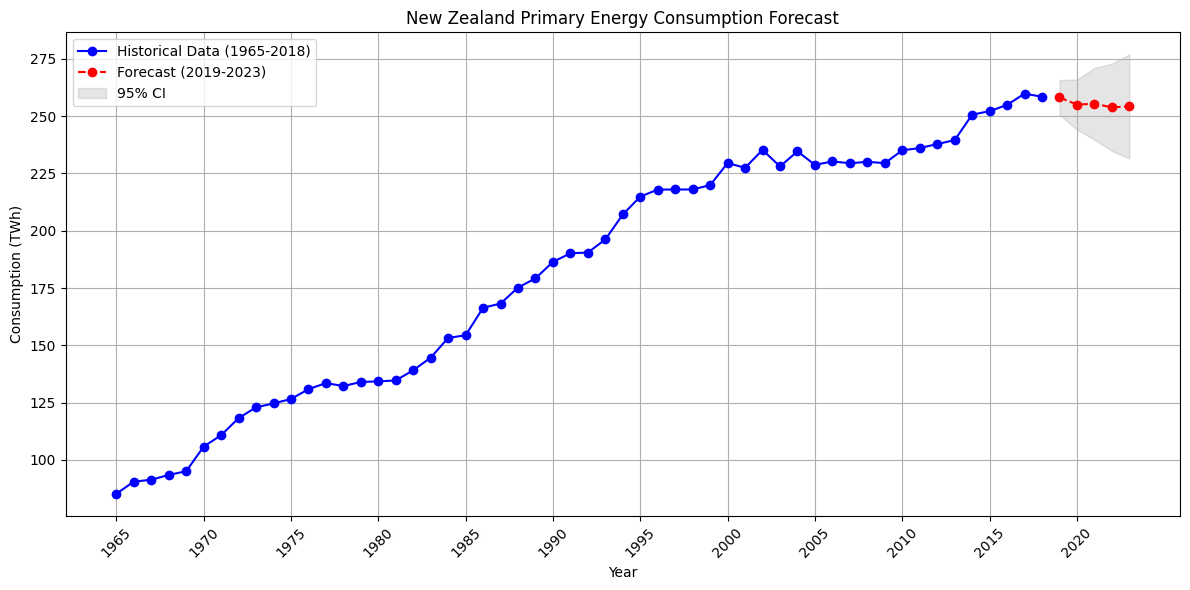

SARIMA(1,1,1) - AIC: 258.1
SARIMA(0,1,1) - AIC: 252.9
SARIMA(1,1,0) - AIC: 251.7
SARIMA(2,1,2) - AIC: 245.0

Selected model: SARIMA(2,1,2) with AIC: 245.0

Model Evaluation for primary_energy_consumption:
MAE: 5.08
RMSE: 6.49


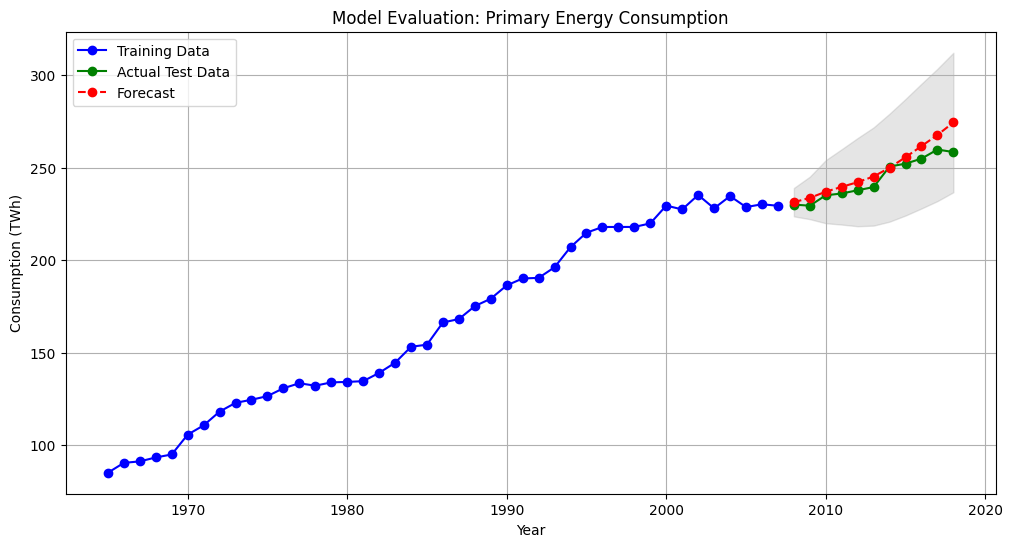


     Renewables Consumption     
SARIMA(1,1,1) - AIC: 316.0
SARIMA(0,1,1) - AIC: 315.3
SARIMA(1,1,0) - AIC: 314.9
SARIMA(2,1,2) - AIC: 319.5

Selected model: SARIMA(1,1,0) with AIC: 314.9


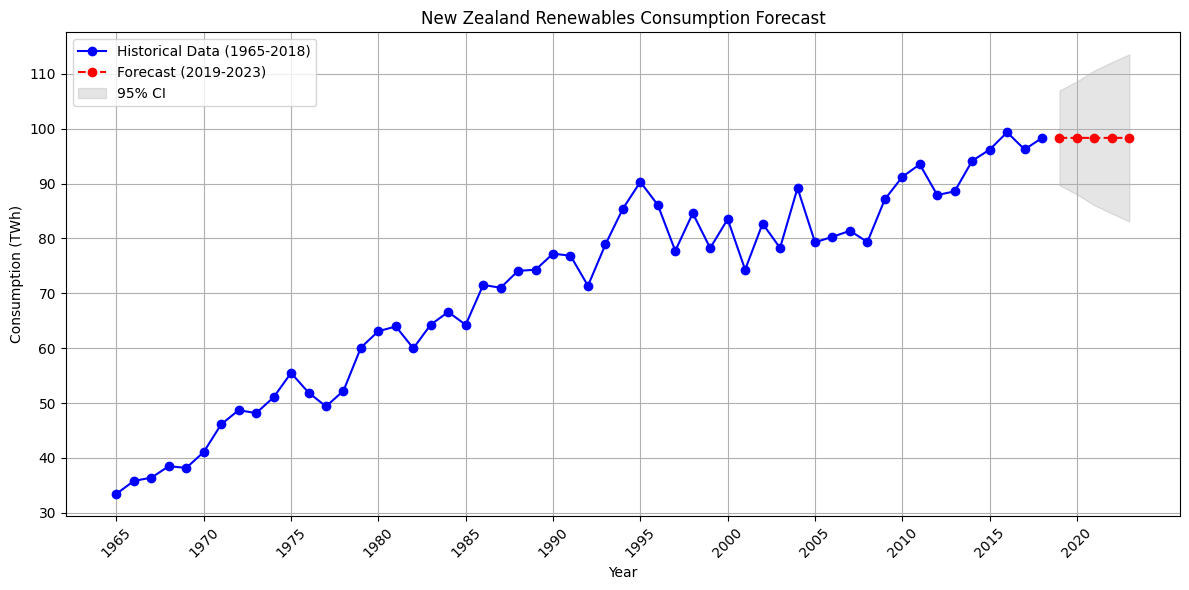

SARIMA(1,1,1) - AIC: 253.3
SARIMA(0,1,1) - AIC: 254.5
SARIMA(1,1,0) - AIC: 252.9
SARIMA(2,1,2) - AIC: 258.3

Selected model: SARIMA(1,1,0) with AIC: 252.9

Model Evaluation for renewables_consumption:
MAE: 4.61
RMSE: 5.32


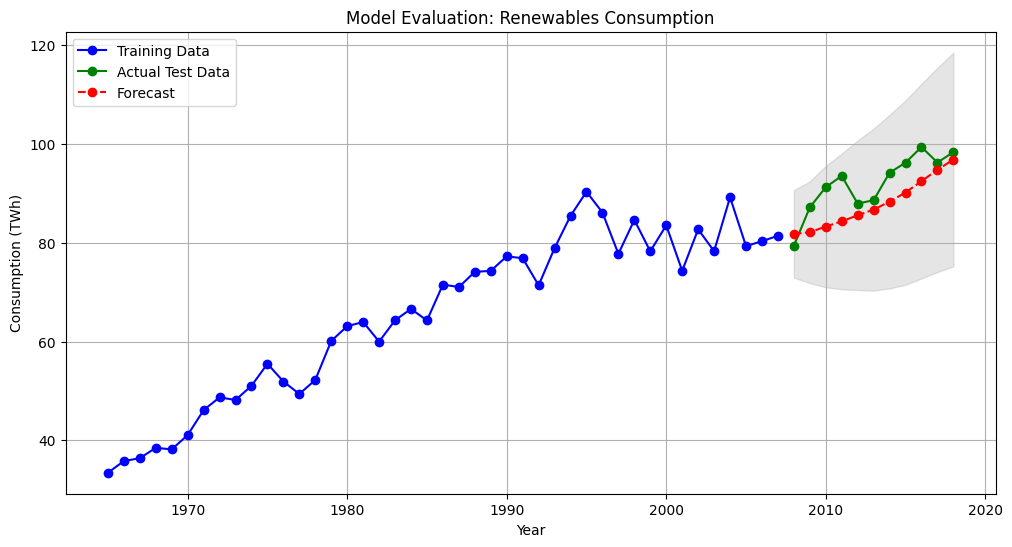


     2030 Projection     
Primary Energy: 254.26 TWh
Renewables: 98.34 TWh
Renewable Share: 38.7%


In [159]:
country = 'New Zealand'
report = generate_energy_report(country)

In [160]:
def visualize_energy_forecast(country, target_column, years_to_forecast=12):
    # Load and prepare data
    data = load_and_prepare_data()
    country_data = data[data['country'] == country]
    series = country_data[target_column]
    
    # Proper year index
    series.index = series.index.astype(int)
    
    # Verify dataset ends in 2022
    last_data_year = series.index[-1]
    if last_data_year != 2022:
        print(f"Warning: Dataset ends in {last_data_year}, not 2022 as expected")
    
    # Model selection based on target_column
    if target_column == 'primary_energy_consumption':
        order = (2, 1, 2) 
        model_name = "SARIMA(2,1,2)"
    else:
        order = (1, 1, 0) 
        model_name = "SARIMA(1,1,0)"
    
    # Fit model with error handling
    try:
        model = SARIMAX(series, order=order, seasonal_order=(0,0,0,0))
        model_fit = model.fit(disp=False)
    except Exception as e:
        print(f"Model fitting failed: {str(e)}")
        return None
    
    # Generate forecast through 
    forecast_years = range(last_data_year + 1, last_data_year + years_to_forecast + 1)
    forecast = model_fit.get_forecast(steps=years_to_forecast)
    forecast_mean = forecast.predicted_mean
    forecast_mean.index = forecast_years
    conf_int = forecast.conf_int()
    conf_int.index = forecast_years
    
    # Create enhanced visualization
    plt.figure(figsize=(14, 7))
    
    # Plot historical data
    plt.plot(series.index, series, 'b-', 
            label=f'Historical Data ({series.index[0]}-{last_data_year})',
            linewidth=2.5,
            alpha=0.8)
    
    # Plot forecast
    plt.plot(forecast_mean.index, forecast_mean, 'r--', 
            label=f'Forecast ({forecast_years[0]}-{forecast_years[-1]})',
            linewidth=2.5,
            marker='o',
            markersize=6)
    
    # Enhanced confidence interval visualization
    plt.fill_between(forecast_mean.index,
                   conf_int.iloc[:, 0],
                   conf_int.iloc[:, 1],
                   color='salmon', alpha=0.2, label='95% CI')
     
    plt.axvline(x=last_data_year, color='gray', linestyle=':', alpha=0.7, linewidth=2)
    
    # Formatting
    plt.title(f'{country} {target_column.replace("_", " ").title()} Forecast\n({model_name})',
             fontsize=14, pad=20)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Consumption (TWh)', fontsize=12)
    
    start_year = max(2000, series.index[0] - (series.index[0] % 5))
    end_year = 2035
    plt.xticks(range(start_year, end_year, 5), rotation=45)
    plt.xlim(start_year, end_year - 1)
    
    # Add value annotations for last 5 years and forecast
    def annotate_values(years, values, offset=10):
        for year, value in zip(years, values):
            plt.annotate(f'{value:.1f}',
                       (year, value),
                       textcoords="offset points",
                       xytext=(0, offset),
                       ha='center',
                       fontsize=9,
                       bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.7))
    
    # Annotate last 5 historical and first 5 forecast points
    annotate_years = list(range(max(2018, last_data_year - 4), last_data_year + 1)) 
    annotate_values(annotate_years, series.loc[annotate_years])
    annotate_values(forecast_years[:5], forecast_mean[:5])
    
    # Add model diagnostics
    plt.annotate(f'Model: {model_name}\nAIC: {model_fit.aic:.1f}\nDataset: {series.index[0]}-{last_data_year}',
                xy=(0.02, 0.98),
                xycoords='axes fraction',
                ha='left',
                va='top',
                fontsize=10,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.legend(loc='upper left', fontsize=10)
    plt.grid(True, linestyle=':', alpha=0.5)
    plt.tight_layout()
    
    # Print forecast summary
    forecast_df = pd.DataFrame({
        'Year': forecast_years,
        'Forecast (TWh)': forecast_mean.round(1),
        'Lower Bound': conf_int.iloc[:, 0].round(1),
        'Upper Bound': conf_int.iloc[:, 1].round(1)
    })
    
    print(f"\n{country} {target_column.replace('_', ' ').title()} Forecast Summary ({model_name})")
    print(forecast_df.to_string(index=False))
    
    plt.show()
    return forecast_df


New Zealand Primary Energy Consumption Forecast Summary (SARIMA(2,1,2))
 Year  Forecast (TWh)  Lower Bound  Upper Bound
 2019           261.4        253.9        269.0
 2020           262.9        252.2        273.6
 2021           265.5        250.7        280.3
 2022           267.0        248.7        285.2
 2023           269.3        246.9        291.6
 2024           270.8        244.7        296.8
 2025           272.8        242.6        303.0
 2026           274.3        240.1        308.5
 2027           276.2        237.7        314.7
 2028           277.6        234.9        320.3
 2029           279.3        232.2        326.4
 2030           280.7        229.2        332.2


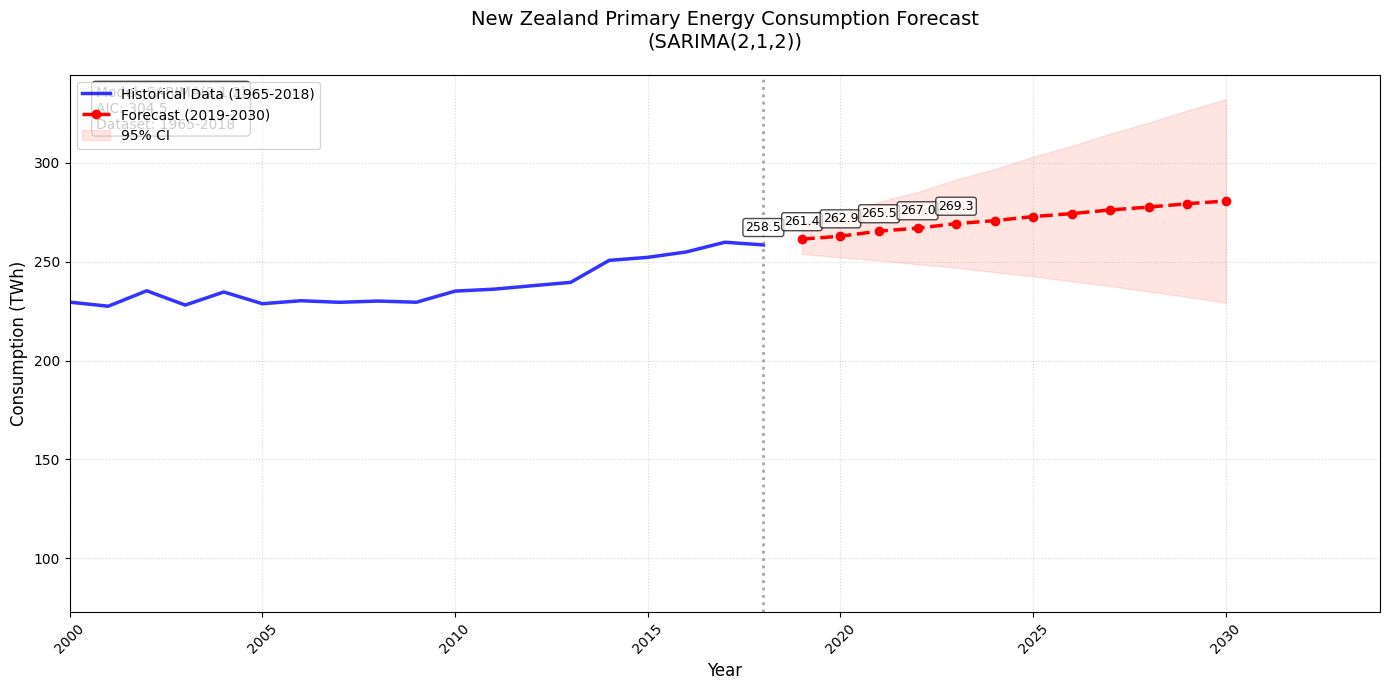


New Zealand Renewables Consumption Forecast Summary (SARIMA(1,1,0))
 Year  Forecast (TWh)  Lower Bound  Upper Bound
 2019            97.7         88.7        106.7
 2020            97.9         86.9        108.9
 2021            97.8         84.7        111.0
 2022            97.9         83.0        112.7
 2023            97.9         81.4        114.3
 2024            97.9         80.0        115.7
 2025            97.9         78.7        117.0
 2026            97.9         77.5        118.2
 2027            97.9         76.3        119.4
 2028            97.9         75.2        120.5
 2029            97.9         74.2        121.5
 2030            97.9         73.2        122.5


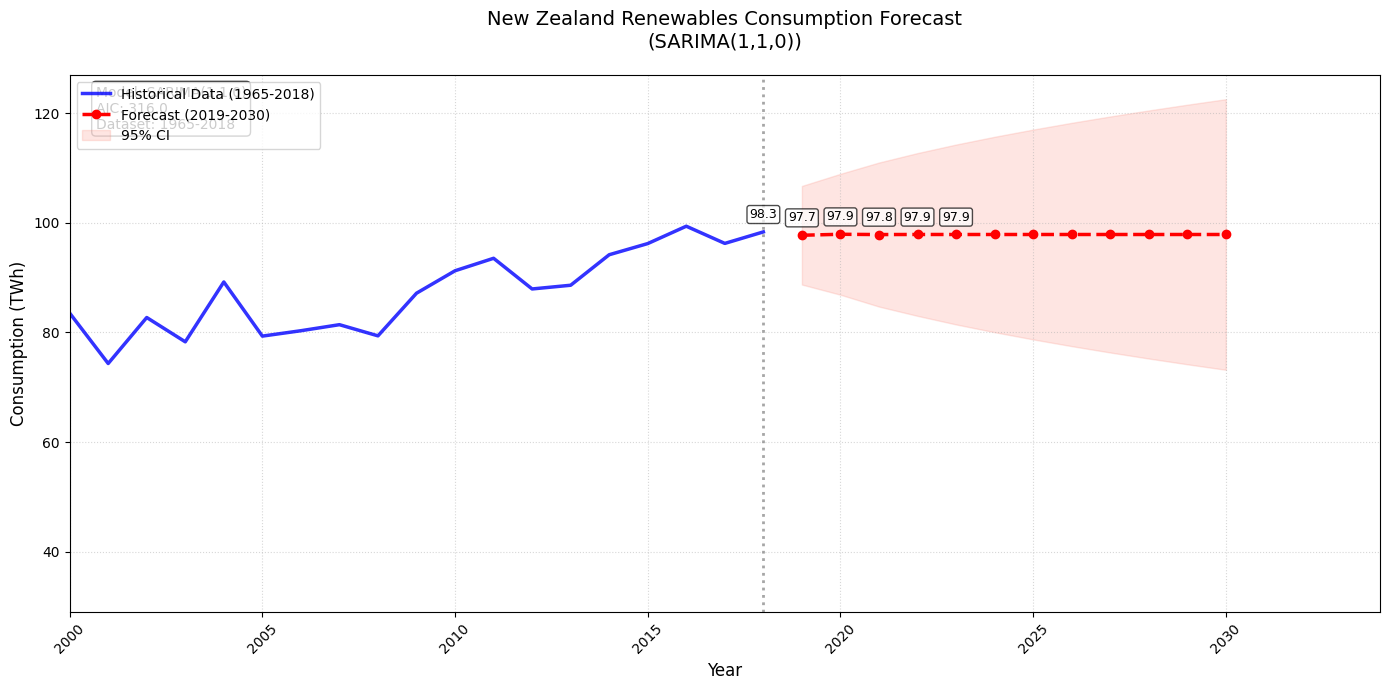

,Year,Forecast (TWh),Lower Bound,Upper Bound
2019,2019,97.7,88.7,106.7
2020,2020,97.9,86.9,108.9
2021,2021,97.8,84.7,111.0
2022,2022,97.9,83.0,112.7
2023,2023,97.9,81.4,114.3
2024,2024,97.9,80.0,115.7
2025,2025,97.9,78.7,117.0
2026,2026,97.9,77.5,118.2
2027,2027,97.9,76.3,119.4
2028,2028,97.9,75.2,120.5


In [161]:

visualize_energy_forecast('New Zealand', 'primary_energy_consumption')

visualize_energy_forecast('New Zealand', 'renewables_consumption')